In [630]:
import os
import time
import numpy as np
import pandas as pd
from radar.dataparsing.td_textdata_parser import read_columns
from scipy.fftpack import fft
from matplotlib import pyplot as plt

td_data = []
runNumber = 7
directory_to_process = f"data/radar/run{runNumber}-TD"
# directory_to_process = f"output/2024-09-29_20-20-41/radar"

def process_data_from_folder(self):
        
        # List all files in the directory
        files = os.listdir(directory_to_process)
        
        # Filter the files based on the naming convention
        txt_files = [f for f in files if f.startswith(('trial', 'TD')) and f.endswith('.txt')]
        
        # Sort the files if needed (optional)
        txt_files.sort()
        
        # Process each file one by one
        for file_name in txt_files:
            file_path = os.path.join(directory_to_process, file_name)
            # print(f"Processing file: {file_path}")
            new_fd_data = read_columns(file_path)
            td_data.append(new_fd_data.td_data)
            
process_data_from_folder(directory_to_process)
td_data = np.array(td_data)
I1_data = td_data[:, :, 0]  # Extract the I1 signal, which is the first column across all frames and range bins
Q1_data = td_data[:, :, 1]  # Extract the Q1 signal, which is the second column across all frames and range bins
I2_data = td_data[:, :, 2]  # Extract the I2 signal, which is the third column across all frames and range bins
Q2_data = td_data[:, :, 3]  # Extract the IQ2 signal, which is the fourth column across all frames and range bins
Complex_data1 = I1_data + 1j * Q1_data

## Populate all the radar variables required:
TIME_STEP = 0.241
WAVELENGTH = 0.01233714
C = 299792458  # Speed of light (m/s)

f_0 = 24e9  # Center Frequency (Hz)
f_c = 24.500e9  # Center Frequency (Hz)
f_chirp = 1e-3  # Chirp Sequence Frequency (Hz)
f_r = 750e6  # Ramp Frequency (Hz)
T_r = 1 / f_chirp  # Duration of one cycle (s)
m_w = f_r / T_r  # Slope of the ramp (Hz/s)
n_r = I1_data.shape[0] # number of total chirps - assumes all have the same shape, which they should
n_s = I1_data.shape[1] # number of samples - assumes all have the same shape, which they should
T_M = T_r * n_r  # Total measurement time (s)
f_s = 1 / TIME_STEP

SINGLE_TO_PROCESS = I1_data

print(f"Num samples: {td_data.shape[0]}")

Num samples: 2302


### Visualize the Chirp Sequence

Text(0.5, 1.0, 'Chirp sequence Modulation, transmitted signal $f_t(t)$')

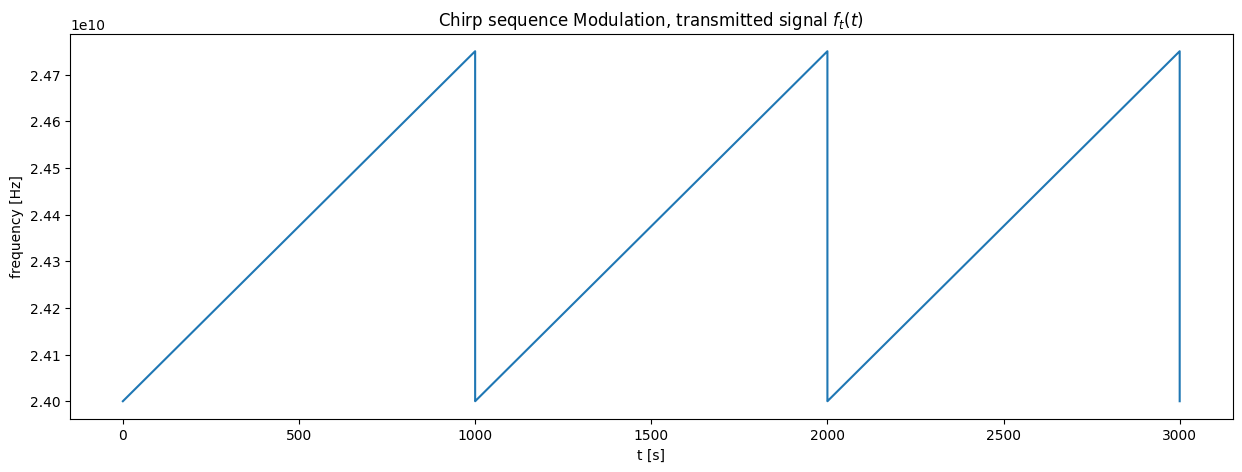

In [631]:
def f_transmitted(t):
    return f_0 + m_w*(t%T_r)

def chirp(t):
    return np.cos(2*np.pi*(f_transmitted(t))*t)

t = np.linspace(0, 3*T_r, int(1e6))

plt.figure(figsize=(15,5))
plt.plot(t, f_transmitted(t))
plt.xlabel("t [s]")
plt.ylabel("frequency [Hz]")
plt.title("Chirp sequence Modulation, transmitted signal $f_t(t)$")

### Show Data in Frame

In [632]:
# Plot the signals

import matplotlib.pyplot as plt
import numpy as np

def plot_I1_Q1(td_data, sample_index=0):
    """
    Plots the I1 and Q1 signal's voltage for the specified sample index.
    
    Parameters:
    td_data (np.array): 3D numpy array of shape (224, 1024, 4)
                        where the last dimension represents [I1, Q1, I2, Q2] signals.
    sample_index (int): The index of the sample to plot.
    
    Returns:
    None
    """
    # Extracting I1 and Q1 signals
    I1 = td_data[sample_index, :, 0]  # I1 signal
    Q1 = td_data[sample_index, :, 1]  # Q1 signal
    
    # Create a time array based on the number of samples (1024)
    time_array = np.linspace(0, len(I1), len(I1))
    
    # Plot the I1 signal
    plt.figure(figsize=(10, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(time_array, I1, label="I1 Signal", color="blue")
    plt.title(f"I1 Signal for Sample {sample_index}")
    plt.xlabel("Time (arbitrary units)")
    plt.ylabel("Voltage (V)")
    plt.grid(True)
    
    # Plot the Q1 signal
    plt.subplot(2, 1, 2)
    plt.plot(time_array, Q1, label="Q1 Signal", color="green")
    plt.title(f"Q1 Signal for Sample {sample_index}")
    plt.xlabel("Time (arbitrary units)")
    plt.ylabel("Voltage (V)")
    plt.grid(True)
    
    # Display the plots
    plt.tight_layout()
    plt.show()

In [633]:
# Assuming I1_data is a 2D array or list with 224 rows and 1024 columns
# For demonstration, let's create a random DataFrame with the specified shape
print(f"Signal Processing shape: {SINGLE_TO_PROCESS.shape}")

# Create a DataFrame for the I1 signal
df_I1_signal = pd.DataFrame(SINGLE_TO_PROCESS,
                            index=["Chirp_%03d"%i for i in range(n_r)],
                            columns=["Sample_%03d"%i for i in range(n_s)])

# Display the first 10 rows of the DataFrame
df_I1_signal.head(10)

Signal Processing shape: (2302, 1024)


Sample_000  Sample_001  Sample_002  Sample_003  Sample_004  \
Chirp_000      1.3184      1.3242      1.3336      1.3407      1.3438   
Chirp_001      1.3220      1.3240      1.3293      1.3356      1.3401   
Chirp_002      1.3231      1.3259      1.3304      1.3334      1.3361   
Chirp_003      1.3288      1.3319      1.3336      1.3341      1.3352   
Chirp_004      1.3218      1.3235      1.3282      1.3334      1.3385   
Chirp_005      1.3182      1.3220      1.3277      1.3345      1.3398   
Chirp_006      1.3271      1.3290      1.3328      1.3370      1.3409   
Chirp_007      1.3233      1.3288      1.3347      1.3378      1.3398   
Chirp_008      1.3248      1.3235      1.3229      1.3239      1.3270   
Chirp_009      1.3323      1.3332      1.3352      1.3374      1.3389   

           Sample_005  Sample_006  Sample_007  Sample_008  Sample_009  ...  \
Chirp_000      1.3442      1.3436      1.3444      1.3462      1.3488  ...   
Chirp_001      1.3434      1.3453      1.3462      1.3471      1.3488  ...   
Chirp_002      1.3387      1.3422      1.3466      1.3499      1.3524  ...   
Chirp_003      1.3365      1.3396      1.3420      1.3429      1.3431  ...   
Chirp_004      1.3416      1.3453      1.3484      1.3500      1.3499  ...   
Chirp_005      1.3416      1.3416      1.3407      1.3407      1.3418  ...   
Chirp_006      1.3418      1.3414      1.3418      1.3442      1.3466  ...   
Chirp_007      1.3398      1.3387      1.3391      1.3414      1.3455  ...   
Chirp_008      1.3310      1.3348      1.3389      1.3425      1.3466  ...   
Chirp_009      1.3403      1.3438      1.3473      1.3504      1.3530  ...   

           Sample_1014  Sample_1015  Sample_1016  Sample_1017  Sample_1018  \
Chirp_000       1.2821       1.2845       1.2854       1.2847       1.2841   
Chirp_001       1.2790       1.2816       1.2856       1.2885       1.2885   
Chirp_002       1.2836       1.2852       1.2859       1.2859       1.2856   
Chirp_003       1.2808       1.2805       1.2805       1.2799       1.2797   
Chirp_004       1.2841       1.2827       1.2810       1.2792       1.2799   
Chirp_005       1.2786       1.2786       1.2768       1.2757       1.2777   
Chirp_006       1.2902       1.2907       1.2907       1.2911       1.2902   
Chirp_007       1.2810       1.2816       1.2819       1.2817       1.2823   
Chirp_008       1.2839       1.2836       1.2816       1.2806       1.2812   
Chirp_009       1.2803       1.2819       1.2823       1.2830       1.2847   

           Sample_1019  Sample_1020  Sample_1021  Sample_1022  Sample_1023  
Chirp_000       1.2834       1.2823       1.2827       1.2839       1.2863  
Chirp_001       1.2872       1.2861       1.2852       1.2854       1.2869  
Chirp_002       1.2865       1.2881       1.2902       1.2911       1.2918  
Chirp_003       1.2801       1.2808       1.2823       1.2836       1.2850  
Chirp_004       1.2821       1.2845       1.2870       1.2889       1.2898  
Chirp_005       1.2808       1.2832       1.2854       1.2881       1.2898  
Chirp_006       1.2891       1.2880       1.2891       1.2900       1.2903  
Chirp_007       1.2843       1.2878       1.2902       1.2887       1.2867  
Chirp_008       1.2827       1.2845       1.2867       1.2885       1.2900  
Chirp_009       1.2878       1.2900       1.2913       1.2907       1.2903  

[10 rows x 1024 columns]

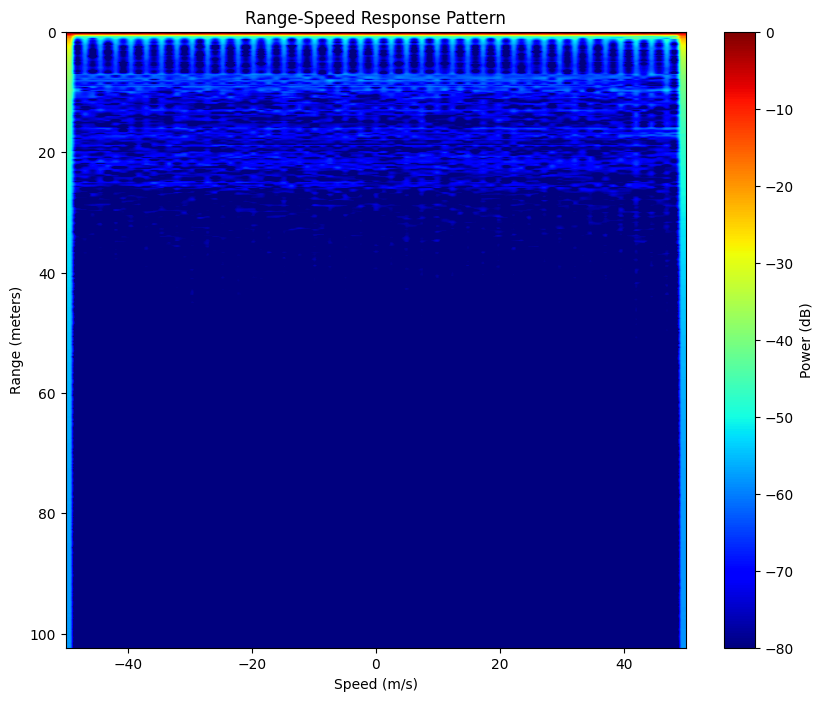

In [703]:
from scipy.signal import stft
from  scipy import signal               
iq1 = df_I1_signal.values.flatten()
num_samples = 1024
bin_size_m = 199.861e-3
bin_size_hz = 1017  
max_speed_limit = 50  # Set a realistic max speed limit (in m/s)
batch_size = 40
start_index = 0
end_index = start_index + batch_size
range_bins = np.linspace(0, bin_size_m * num_samples/2, num_samples)

time_segment = df_I1_signal.iloc[start_index:end_index].values.flatten()

# Different windows that could be used
hann_window = signal.windows.hann(num_samples)
blackman_window = signal.windows.blackman(num_samples)
beta = 5  # Adjust this value (e.g., 8 to 12) for better sidelobe suppression
kaiser_window = signal.windows.kaiser(num_samples, beta)


# STFT Calculation with nperseg=1024 for full chirp length
frequencies, times, Zxx = stft(time_segment, fs=0.241, nperseg=1024, noverlap=512)
# Convert to range and speed
doppler_freq_bins  = np.fft.fftshift(np.fft.fftfreq(Zxx.shape[1], d=1/num_samples)) * bin_size_hz
speed_bins = (C * doppler_freq_bins) / (2 * f_c)
# Ensure that the speed conversion is consistent and reasonable
speed_bins = np.clip(speed_bins, -max_speed_limit, max_speed_limit)

# Plotting the Range-Speed Response Pattern
plt.figure(figsize=(10, 8))
plt.imshow(20 * np.log10(np.abs(Zxx)), extent=[speed_bins.min(), speed_bins.max(), range_bins.max(), range_bins.min()],
           aspect='auto', cmap='jet', vmax=0, vmin=-80)
plt.colorbar(label='Power (dB)')
plt.xlabel('Speed (m/s)')
plt.ylabel('Range (meters)')
plt.title('Range-Speed Response Pattern')
# plt.xlim(-50, 50)
plt.show()


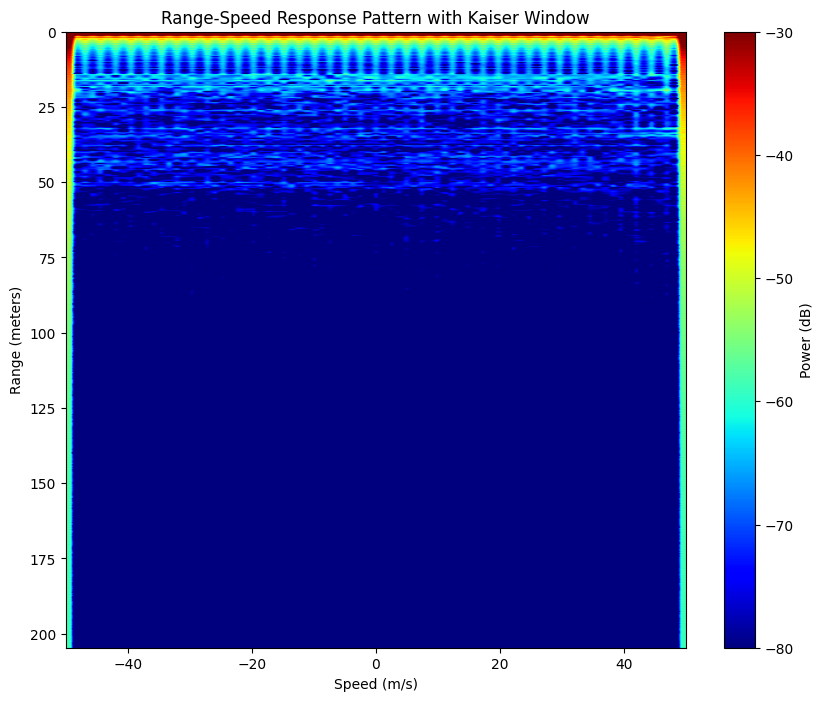

In [704]:
# STFT Calculation with nperseg=1024 for full chirp length
frequencies, times, Zxx = stft(time_segment, fs=1e3, window=kaiser_window, nperseg=1024, noverlap=512)

# Convert Doppler frequencies to speed
doppler_freq_bins = np.fft.fftshift(np.fft.fftfreq(Zxx.shape[1], d=1/num_samples)) * bin_size_hz
speed_bins = (C * doppler_freq_bins) / (2 * f_c)

# Ensure that the speed conversion is consistent and reasonable
speed_bins = np.clip(speed_bins, -max_speed_limit, max_speed_limit)

# Plotting the Range-Speed Response Pattern
plt.figure(figsize=(10, 8))
plt.imshow(20 * np.log10(np.abs(Zxx)), extent=[speed_bins.min(), speed_bins.max(), bin_size_m * num_samples, 0],
           aspect='auto', cmap='jet', vmax=-30, vmin=-80)
plt.colorbar(label='Power (dB)')
plt.xlabel('Speed (m/s)')
plt.ylabel('Range (meters)')
plt.title('Range-Speed Response Pattern with Kaiser Window')
plt.show()

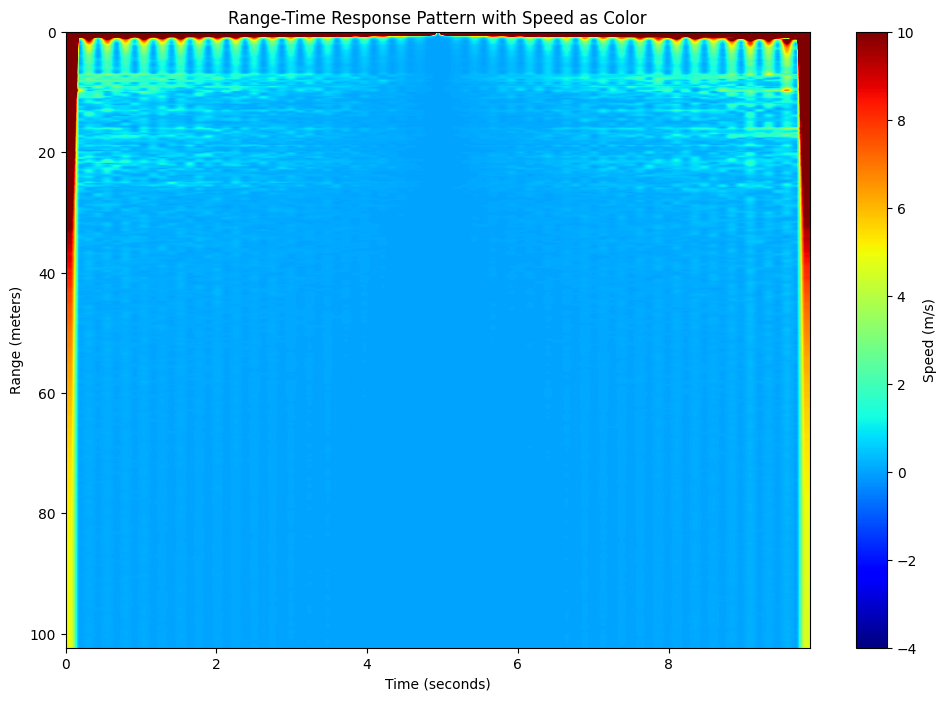

In [706]:

from scipy.signal import stft
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

# Extract the time segment from df_I1_signal (flattened)
time_segment = df_I1_signal.iloc[start_index:end_index].values.flatten()

# STFT Calculation with nperseg=1024 for full chirp length
blackman_window = signal.windows.blackman(num_samples)
frequencies, times, Zxx = stft(time_segment, fs=1/1e-3, window=blackman_window, nperseg=1024, noverlap=512)

# Convert to range bins and adjust time bins with time step
time_bins = times * TIME_STEP  # Adjust time axis based on time step

# Convert Doppler frequencies to speed
doppler_freq_bins = np.fft.fftshift(np.fft.fftfreq(Zxx.shape[1], d=1/num_samples)) * bin_size_hz
speed_bins = (C * doppler_freq_bins) / (2 * f_c)
# Ensure that the speed conversion is consistent and reasonable

# Calculate the speed magnitude for color mapping
speed_magnitude = np.abs(speed_bins[np.newaxis, :] * np.abs(Zxx))

# Plotting the Range-Time Response Pattern with Speed as Color
plt.figure(figsize=(12, 8))
plt.imshow(speed_magnitude, extent=[time_bins.min(), time_bins.max(), range_bins.max(), range_bins.min()],
           aspect='auto', cmap='jet', vmax=10, vmin=-4)
plt.colorbar(label='Speed (m/s)')
plt.xlabel('Time (seconds)')
plt.ylabel('Range (meters)')
plt.title('Range-Time Response Pattern with Speed as Color')

plt.show()

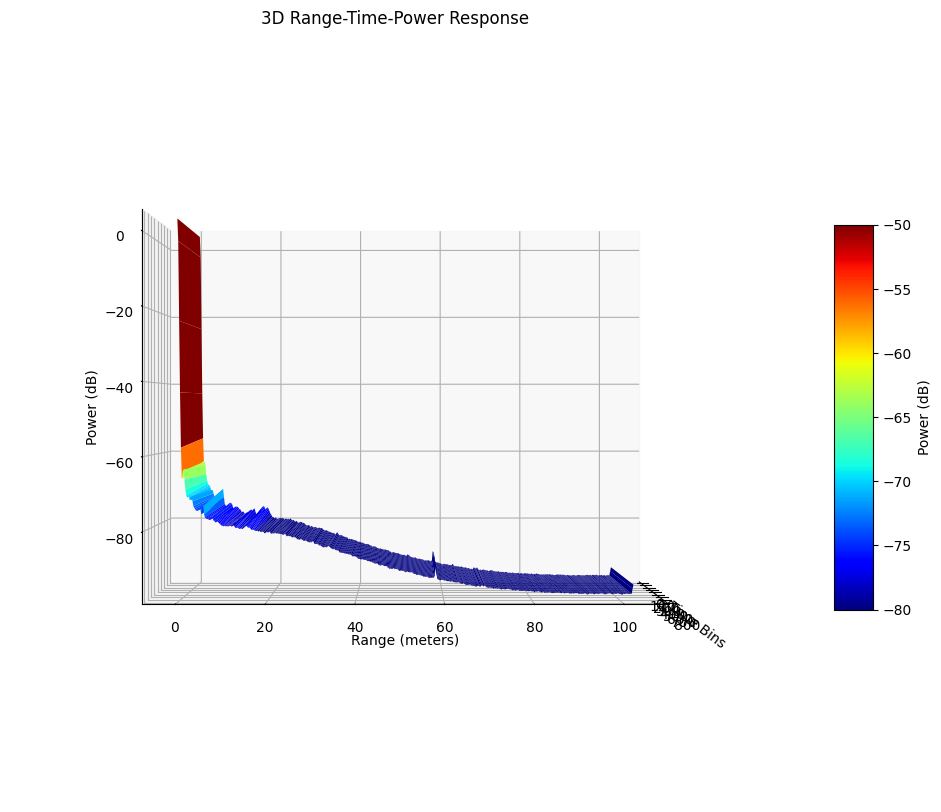

In [637]:
# Initialize list to store power data
power_3d = []

# Iterate through the DataFrame in batches of 10 chirps
num_batches = df_I1_signal.shape[0] // batch_size

for i in range(num_batches):
    # Select a batch of 10 chirps
    batch_data = df_I1_signal.iloc[i * batch_size:(i + 1) * batch_size].values.flatten()

    # STFT for the current batch
    frequencies, times, Zxx = stft(batch_data, fs=1/1-3, nperseg=1024, noverlap=512)

    # Calculate power in dB
    Zxx_dB = 20 * np.log10(np.abs(Zxx) + 1e-12)  # Add a small value to avoid log(0)
    
    # Append the mean power over time to power_3d
    power_3d.append(np.mean(Zxx_dB, axis=1))

# Convert power data to a 2D array
power_3d = np.array(power_3d).T  # Shape should be (num_freq_bins, num_batches)

# Define range bins based on the number of frequency bins in STFT output
range_bins = np.linspace(0, bin_size_m * power_3d.shape[0], power_3d.shape[0])

# Define time bins for each batch
time_bins = np.arange(num_batches) * batch_size

# Create a meshgrid for time and range
X, Y = np.meshgrid(time_bins, range_bins)

# Plotting the 3D Range-Time-Power Response
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Normalize the power data for color mapping
norm = plt.Normalize(vmin=-80, vmax=-50)
colors = plt.cm.jet(norm(power_3d))

# Plot surface with color representing power
surf = ax.plot_surface(X, Y, power_3d, facecolors=colors, rstride=1, cstride=1, 
                       antialiased=True, linewidth=0, shade=False)

# Add color bar for power
mappable = plt.cm.ScalarMappable(cmap='jet', norm=norm)
mappable.set_array(power_3d)
cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Power (dB)')

# Set labels
ax.set_xlabel('Time Bins')
ax.set_ylabel('Range (meters)')
ax.set_zlabel('Power (dB)')
ax.set_title('3D Range-Time-Power Response')

ax.view_init(elev=0, azim=0, roll=0)  # Adjust elev and azim as needed
plt.show()

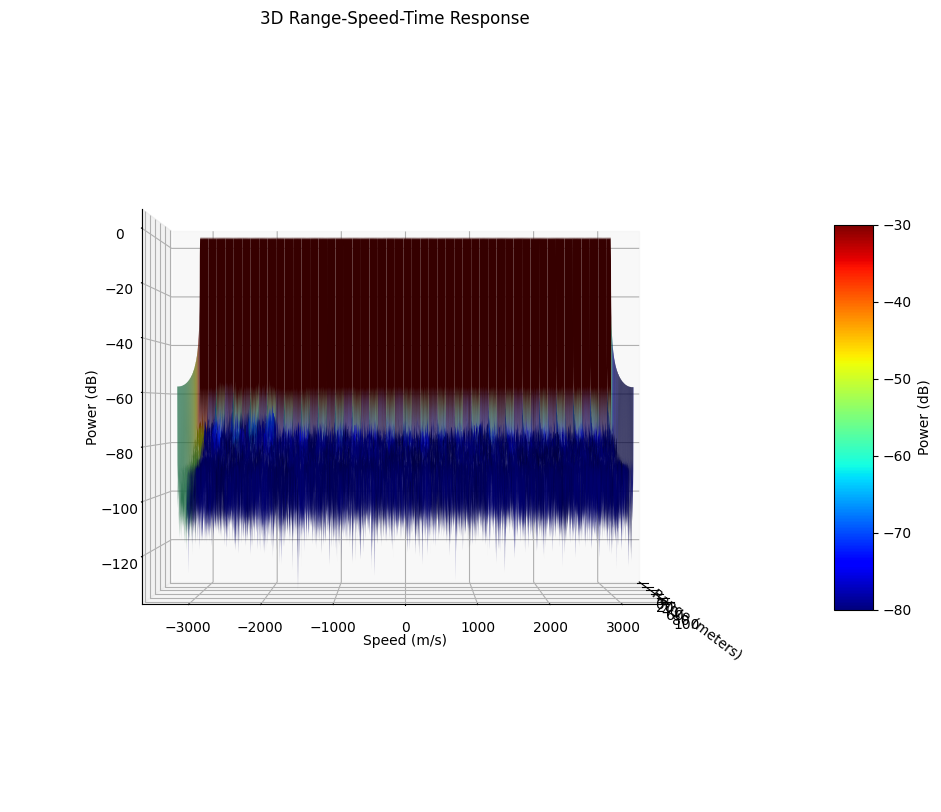

In [638]:
range_speed_time = []

# Iterate through the DataFrame in batches of 10 chirps
num_batches = df_I1_signal.shape[0] // batch_size

for i in range(num_batches):
    # Select a batch of 10 chirps
    batch_data = df_I1_signal.iloc[i * batch_size:(i + 1) * batch_size].values.flatten()

    # STFT Calculation with nperseg=1024 for full chirp length
    frequencies, times, Zxx = stft(batch_data, fs=1/1e-3, nperseg=1024, noverlap=512)

    # Convert to range and speed bins
    range_bins = np.linspace(0, bin_size_m * Zxx.shape[0], Zxx.shape[0])  # Adjust to match Zxx shape
    doppler_freq_bins = np.fft.fftshift(np.fft.fftfreq(Zxx.shape[1], d=1/num_samples)) * bin_size_hz
    speed_bins = (C * doppler_freq_bins) / (2 * f_c)

    # Calculate power in dB and append to list
    power_dB = 20 * np.log10(np.abs(Zxx) + 1e-12)
    range_speed_time.append(power_dB)

# Convert range-speed-time data to 3D array
range_speed_time = np.array(range_speed_time)  # Shape: (num_batches, 513, num_speed_bins)

# Define time bins for each batch
time_bins = np.arange(num_batches) * batch_size

# Create a meshgrid for range, speed, and time
X, Y = np.meshgrid(range_bins, speed_bins)

# Adjust the shape of the 3D power data for plotting
Z = np.mean(range_speed_time, axis=0)  # Average over time for visualization

# Plotting the 3D Range-Speed-Time Response
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid for plotting
X, Y = np.meshgrid(range_bins, speed_bins)

# Normalize the power data for color mapping
norm = plt.Normalize(vmin=-80, vmax=-30)
colors = plt.cm.jet(norm(Z.T))

# Plot surface with color representing power
surf = ax.plot_surface(X, Y, Z.T, facecolors=colors, antialiased=True, linewidth=0, shade=True)

# Add color bar for power
mappable = plt.cm.ScalarMappable(cmap='jet', norm=norm)
mappable.set_array(Z.T)
cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Power (dB)')

# Set labels
ax.set_xlabel('Range (meters)')
ax.set_ylabel('Speed (m/s)')
ax.set_zlabel('Power (dB)')
ax.set_title('3D Range-Speed-Time Response')
ax.view_init(elev=0, azim=0, roll=0)
plt.show()

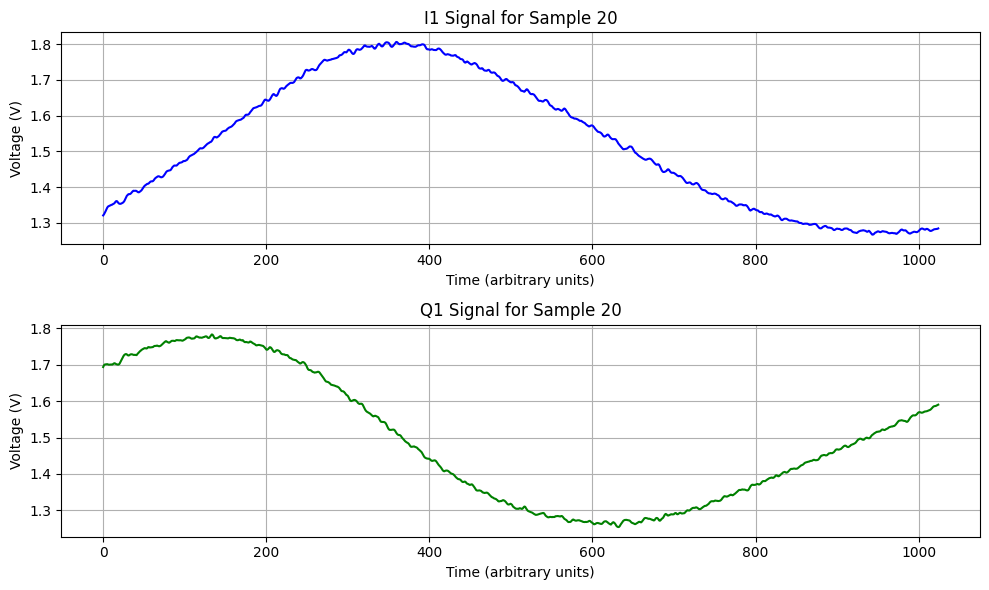

In [639]:
plot_I1_Q1(td_data, sample_index=20) # are up to 0-223 samples for FD6

### FTT Over the First Chirp - I1

In [640]:
ramp_time_ms = 1  # Ramp time in milliseconds
f_s = n_s / (ramp_time_ms * 1e-3) # Sampling frequency, number of samples per second! 

sample_n = 25
chirpn_samples = df_I1_signal.iloc[sample_n].values
chirpn_magnitude = fft(chirpn_samples)
frequencies = np.arange(0, n_s//2)*f_s/n_s

frequencies[:10]


array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000., 8000.,
       9000.])

In [641]:
def freq_to_range(f):
    return f * C / ( 2 * m_w)

# f_star1 = 2 * m_w / C * 100
# f_star2 = 2 * f_0 / C * 33
# print(f_star1, f_star2)
# print(f_star2/f_star1*100, "%")

ranges = freq_to_range(frequencies)
print(ranges[:10])

[      0.          199861.63866667  399723.27733333  599584.916
  799446.55466667  999308.19333333 1199169.832      1399031.47066667
 1598893.10933333 1798754.748     ]


0.0


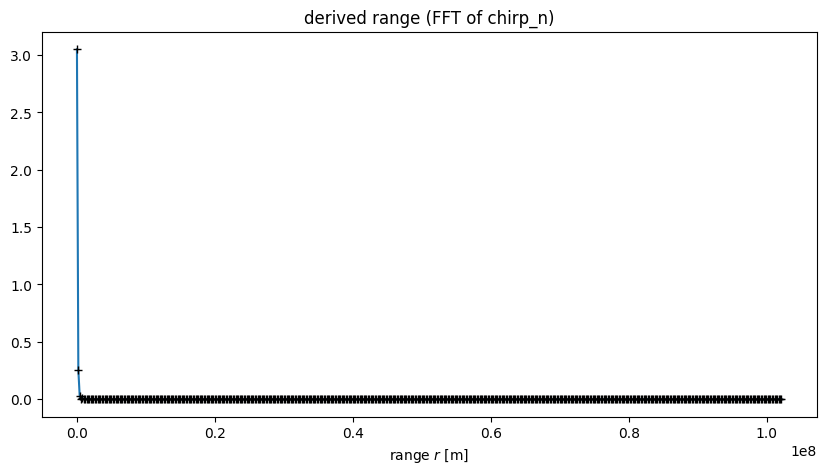

In [642]:
plt.figure(figsize=(10,5))
plt.plot(ranges, 2.0/n_s*np.abs(chirpn_magnitude[0:n_s//2]))
plt.plot(ranges, 2.0/n_s*np.abs(chirpn_magnitude[0:n_s//2]), "k+")
plt.xlabel("range $r$ [m]")
plt.title("derived range (FFT of chirp_n)")
print(freq_to_range(frequencies)[np.argmax(2.0/n_s*np.abs(chirpn_magnitude[0:n_s//2]))])

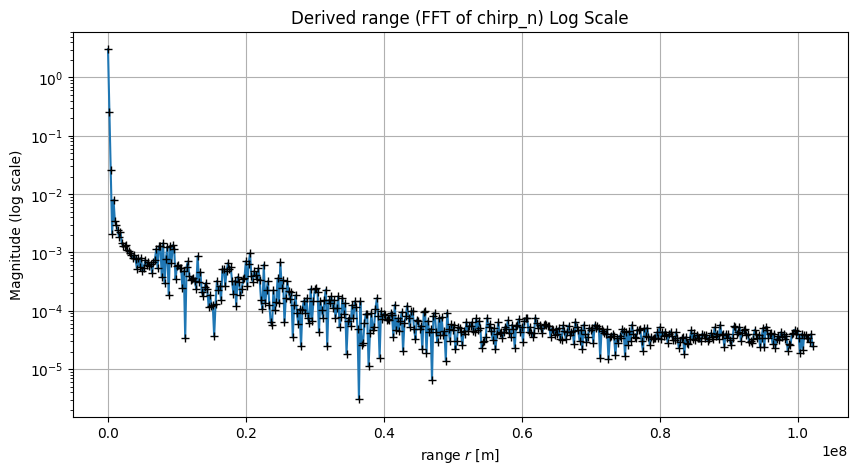

0.0


In [643]:
plt.figure(figsize=(10, 5))

# Plot the FFT magnitude
plt.plot(ranges, 2.0/n_s * np.abs(chirpn_magnitude[0:n_s//2]), label='FFT Magnitude')
plt.plot(ranges, 2.0/n_s * np.abs(chirpn_magnitude[0:n_s//2]), "k+")

# Use a logarithmic scale for the y-axis to handle large differences in magnitude
plt.yscale('log')

# Set labels and title
plt.xlabel("range $r$ [m]")
plt.ylabel("Magnitude (log scale)")
plt.title("Derived range (FFT of chirp_n) Log Scale")

# Optional: grid for better visualization
plt.grid(True)

# Display the plot
plt.show()

# Print the range corresponding to the maximum FFT value
print(freq_to_range(frequencies)[np.argmax(2.0/n_s * np.abs(chirpn_magnitude[0:n_s//2]))])



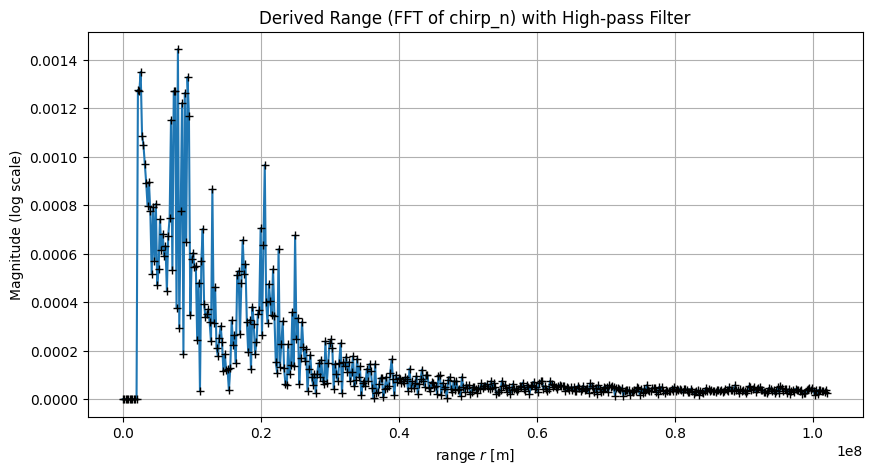

7994465.546666667


In [644]:
cutoff_frequency = 0.01  # Choose a cutoff frequency to remove lower frequency values (close ranges)

# Create a high-pass filter: set all frequencies below the cutoff to zero
frequencies_filter = np.fft.fftfreq(n_s)  # Generate the frequency axis
high_pass_filter = np.abs(frequencies_filter) >= cutoff_frequency

# Apply the high-pass filter by multiplying it with the FFT output
filtered_magnitude = chirpn_magnitude * high_pass_filter

# Plot the filtered FFT magnitude
plt.figure(figsize=(10, 5))
plt.plot(ranges, 2.0/n_s * np.abs(filtered_magnitude[0:n_s//2]), label='Filtered FFT Magnitude')
plt.plot(ranges, 2.0/n_s * np.abs(filtered_magnitude[0:n_s//2]), "k+")

# Use a logarithmic scale for the y-axis to better visualize small values
# plt.yscale('log')

# Set labels and title
plt.xlabel("range $r$ [m]")
plt.ylabel("Magnitude (log scale)")
plt.title("Derived Range (FFT of chirp_n) with High-pass Filter")

# Optional: grid for better visualization
plt.grid(True)

# Display the plot
plt.show()

# Print the range corresponding to the maximum value of the filtered FFT
print(freq_to_range(frequencies)[np.argmax(2.0/n_s * np.abs(filtered_magnitude[0:n_s//2]))])


## Calcualte range bins for each chirp

In [645]:
range_table = np.zeros((n_r, n_s//2), dtype=np.csingle)

In [646]:
for chirp_nr in range(n_r):
    chirp_ad_values = df_I1_signal.iloc[chirp_nr].values
    chirp_fft = fft(chirp_ad_values) # FFT
    
    range_table[chirp_nr, :] = 2.0/n_s*chirp_fft[:n_s//2]

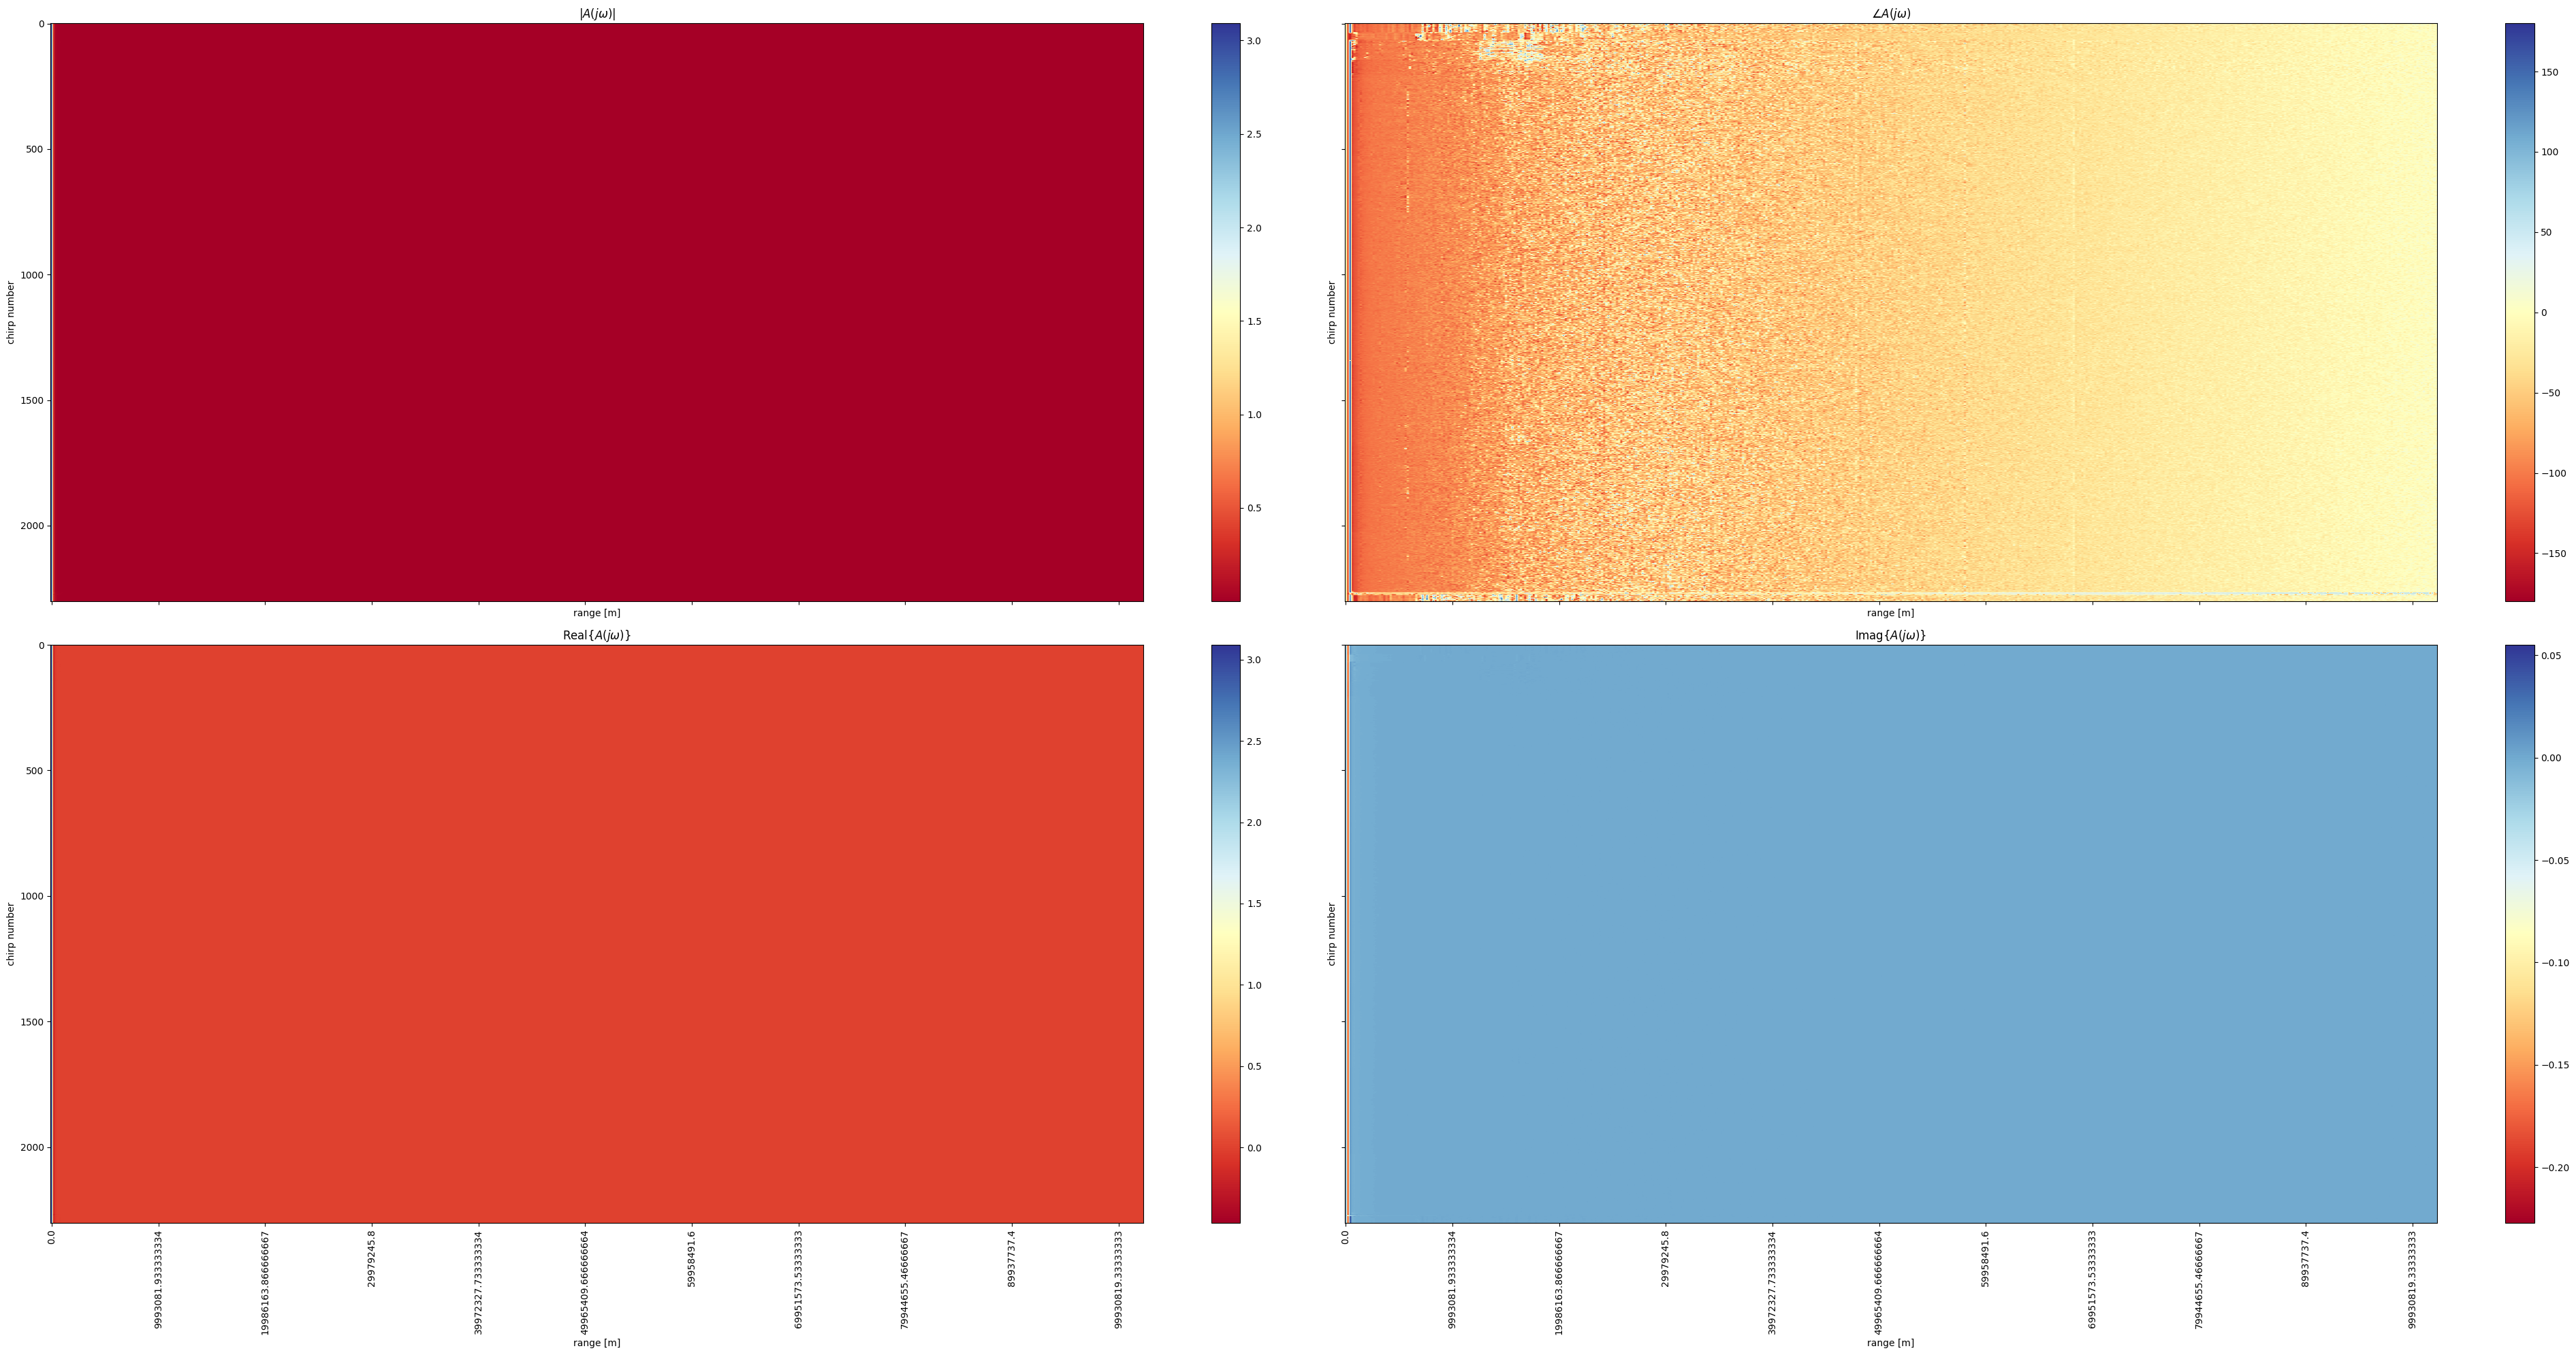

In [647]:
# Adjusting the aspect ratio and improving layout
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(40,20), sharex=True, sharey=True)
abs_axes = ax[0, 0]
phi_axes = ax[0, 1]
real_axes = ax[1, 0]
imag_axes = ax[1, 1]

# Absolute plot
im_asb = abs_axes.imshow(np.abs(range_table), cmap = plt.get_cmap('RdYlBu'), aspect='auto')  # 'auto' ensures the plot scales properly
abs_axes.set_xticks(range(ranges.size)[::50])
abs_axes.set_xticklabels(ranges[::50], rotation=90)
fig.colorbar(im_asb, ax=abs_axes)
abs_axes.set_xlabel("range [m]")
abs_axes.set_ylabel("chirp number")
abs_axes.set_title("$|A(j\omega)|$")

# Phase plot
im_phi = phi_axes.imshow(np.angle(range_table)*360/(2*np.pi), cmap = plt.get_cmap('RdYlBu'), aspect='auto')
fig.colorbar(im_phi, ax=phi_axes)
phi_axes.set_xlabel("range [m]")
phi_axes.set_ylabel("chirp number")
phi_axes.set_title("$∠ A(j\omega)$")
phi_axes.set_xticks(range(ranges.size)[::50])
phi_axes.set_xticklabels(ranges[::50], rotation=90)

# Real plot
im_real = real_axes.imshow(np.real(range_table), cmap = plt.get_cmap('RdYlBu'), aspect='auto')
fig.colorbar(im_real, ax=real_axes)
real_axes.set_xlabel("range [m]")
real_axes.set_ylabel("chirp number")
real_axes.set_title("Real{$A(j\omega)$}")
real_axes.set_xticks(range(ranges.size)[::50])
real_axes.set_xticklabels(ranges[::50], rotation=90)

# Imaginary plot
im_imag = imag_axes.imshow(np.imag(range_table), cmap = plt.get_cmap('RdYlBu'), aspect='auto')
fig.colorbar(im_imag, ax=imag_axes)
imag_axes.set_xlabel("range [m]")
imag_axes.set_ylabel("chirp number")
imag_axes.set_title("Imag{$A(j\omega)$}")
imag_axes.set_xticks(range(ranges.size)[::50])
imag_axes.set_xticklabels(ranges[::50], rotation=90)

# Automatically adjust layout
plt.tight_layout()

### Velocity Estimation

In [648]:
velocity_table = np.zeros((n_r, range_table.shape[1]), dtype=np.csingle)

In [649]:
for r in range(range_table.shape[1]):
    range_bin_magn = range_table[:, r]
    range_bin_fft = fft(range_bin_magn)
    velocity_table[:, r]= 2.0/n_r*range_bin_fft

In [650]:
def angle_freq_to_velocity(w):
    return w*C/(4*np.pi*f_0)

omega_second = 2*np.pi*np.concatenate((np.arange(0, n_r//2), np.arange(-n_r//2, 0)[::-1]))*f_chirp/n_r

In [651]:
velocities = angle_freq_to_velocity(omega_second)

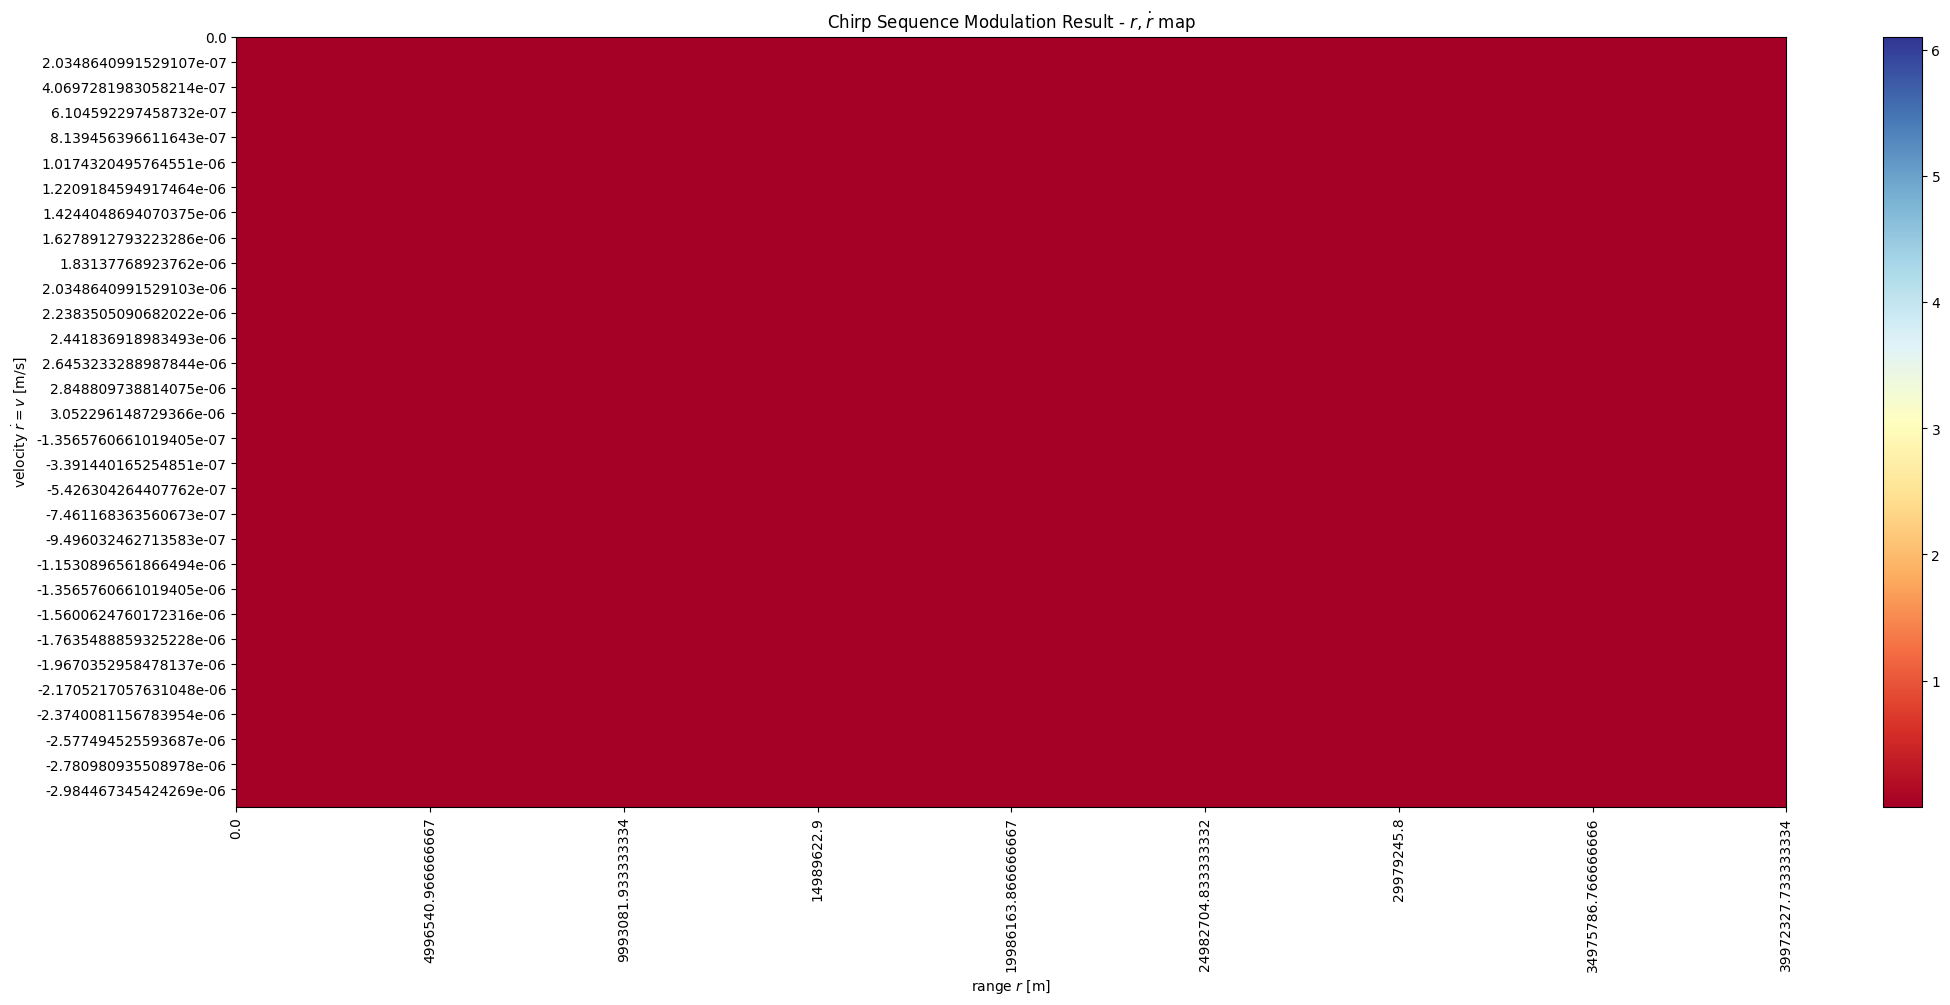

In [652]:
plt.figure(figsize=(25,10))  # Keep the figure size large
plt.imshow(np.abs(velocity_table), cmap = plt.get_cmap('RdYlBu'), aspect='auto')  # Set aspect ratio to 'auto'

# Reduce number of x-axis and y-axis ticks
plt.xticks(range(0, ranges.size, 25), ranges[::25], rotation=90)
plt.yticks(range(0, velocities.size, 75), velocities[::75])

# Set x and y limits
plt.xlim([0, 200])

# Labels and title
plt.xlabel("range $r$ [m]")
plt.ylabel("velocity $\\dot r = v$ [m/s]")
plt.title("Chirp Sequence Modulation Result - $r, \\dot r$ map")

# Colorbar
plt.colorbar()

plt.show()


